In [1]:
# Import des packages
import numpy as np
from numpy import linalg as lg
from matplotlib import pyplot as plt
from scipy import misc
import scipy.stats as sc
from scipy.integrate import quad
from numpy import sinh, sin, cosh, cos, exp, pi, log, abs

# Résolution numérique de l'équation 

$$ -u''+\lambda u = f $$
$$ u(a)=u(b)=0 $$

avec $$ f \in L^2(\Omega) $$

$$ \Omega = ]a,b[ $$

$$ \partial \Omega = \{a,b\} $$

In [2]:
# Fonctions utiles
def f(x) : return x**2 #second membre de l'équation de départ
def un(a1,a2,x) : # fonction caractéristique sur l'intervalle [a1,a2]
    if (a1 < x and x <= a2) : return 1
    else : return 0
def integrale(f,b1,b2) : return quad(f,b1,b2)[0]

In [3]:
def integrale_mult(f,b1,b2,o) :
    if o == 1 : return integrale(f,b1,b2)
    else : return integrale(lambda x : integrale_mult(f,b1,x,o-1),b1,b2)
    
def solution_exacte(x,lam,a,b) :
    
    rac = np.sqrt(np.abs(lam))
    
    if lam>0 :
        Q=integrale(lambda x : sinh(rac*(b-x))*f(x),a,b)/(rac*sinh((a-b)*rac))
        sol_x = Q*sinh((a-x)*rac) - 1./rac * integrale(lambda s : sinh(rac*(x-s))*f(s),a,x)

    if lam==0 : 
        #g = lambda t : integrale(f,a,t)
        sol_x= (a-x)/(a-b) * integrale_mult(f,a,b,2) - integrale_mult(f,a,x,2)
        #sol_x= (a-x)/(a-b) * integrale(g,a,b) - integrale(g,a,x)

    if lam<0 :
        Q=integrale(lambda x : sin(rac*(b-x))*f(x),a,b)/(rac*sin((a-b)*rac))
        sol_x= Q*sin((a-x)*rac) - 1./rac * integrale(lambda s : sin(rac*(x-s))*f(s),a,x)
            
    return sol_x

def solution_numerique(x,u) : 
    res=0
    sol = u[0]
    for i in range(np.size(sol)) :
        res = res + sol[i]*phi(x,i,a,b,np.size(sol))
    return res

In [4]:
def afficher_solutions(u_1, x_1, nom_methode_1, u_2, x_2, nom_methode_2) :
    plt.figure()
    
    if np.size(u_1)<=100 : plt.plot(x_1,u_1,'*')
    else : plt.plot(x_1,u_1)
    
    if np.size(u_2)<=100 : plt.plot(x_2,u_2,'*')
    else : plt.plot(x_2,u_2)
    
    plt.legend((nom_methode_1, nom_methode_2), loc=2)
    
def afficher_solutions_zoom(u_1, x_1, nom_methode_1, u_2, x_2, nom_methode_2, p1, p2) :
    r11,r12= int(p1*np.size(u_1)),int(p2*np.size(u_1))
    r21,r22= int(p1*np.size(u_2)),int(p2*np.size(u_2))
    
    afficher_solutions(u_1[r11:r12],x_1[r11:r12], nom_methode_1, u_2[r21:r22],x_2[r21:r22],nom_methode_2)

In [5]:
# Fonctions chapeaux
def phi(x,i,a,b,n) :
    h=(b-a)/(n+1)
    domaine = np.linspace(a,b,n+2)
    
    yi = (x-domaine[i-1])/h * un(domaine[i-1], domaine[i], x)
    yip1 = (domaine[i+1]-x)/h * un(domaine[i], domaine[i+1], x)
    
    return  yi + yip1 

def methode_elements_finis(l,a,b,n) : 
    h = (b-a)/(n+1)
    domaine = np.linspace(a,b,n+2)
    uns = np.ones(n-1)

    R = 1./h *(2.*np.eye(n) - (np.diag(uns,-1)+np.diag(uns,1))) # Matrice de rigidité
    M = h/6. * (4.*np.eye(n) + (np.diag(uns,-1)+np.diag(uns,1))) # Matrice de masse
    A2 = R+l*M # Matrice de résolution

    F2 = np.zeros(n)
    for j in range(n) :
        F2[j] = integrale(lambda x : f(x)*phi(x,j+1,a,b,n),domaine[j],domaine[j+2])

    zero = np.array([0])
    u_ef = np.concatenate((zero,lg.solve(A2,F2),zero),axis=0) 
    
    return u_ef, domaine

In [6]:
def methode_differences_finies(l,a,b,n) : 
    h=(b-a)/(n+1)
    
    # Maillage
    domaine = np.linspace(a,b,n+2)
    domaine_sans_bords = domaine[1:n+1]
    
    uns = np.ones(n-1)

    A = 1./h**2. * ((2.+l*h**2)*np.eye(n) - (np.diag(uns,1)+np.diag(uns,-1))) # Matrice A
    F=f(domaine_sans_bords) # second membre

    # Resolution (avec ajout de "0" pour l'affichage)
    zero = np.array([0])
    u_df = np.concatenate((zero,lg.solve(A,F),zero),axis=0)
    
    return u_df, domaine

In [8]:
def tracer_erreur(methode,solution_exacte,l,a,b,norme) :
    tailles = [50,100,200,500,1000,2000,5000]
    erreurs = np.zeros(np.size(tailles))
    erreurs_l2 = np.zeros(np.size(tailles))
    erreurs_h10 = np.zeros(np.size(tailles))
    
    for k in range(np.size(tailles)) :
        sol_num_discretise = methode(l,a,b,tailles[k])
        sol_num_fonction = lambda x : solution_numerique(x,sol_num_discretise)
        
        f = lambda x : solution_exacte(x)-sol_num_fonction(x)
        df = lambda x : misc.derivative(f,x)
        
        if norme == "l2" : erreurs[k] = integrale(lambda x : f(x)**2,a,b)
        if norme == "h1" : erreurs[k] = integrale(lambda x : f(x)**2 + df(x)**2,a,b)
            
    log_tailles = list(map(log,tailles))
    log_erreurs = list(map(log,erreurs))
        
    #Regression
    droite = sc.linregress(log_tailles,log_erreurs)
    log_erreurs_linearise = list(map(lambda x : droite.slope*x+droite.intercept,log_tailles))
    
    #Légende
    plt.plot(log_tailles,log_erreurs, '*') #Tracé des log(erreurs) en fonction de log(n)
    plt.plot(log_tailles, log_erreurs_linearise, 'r') #Tracé du linéarisé
    plt.xlabel('log(n)')
    plt.ylabel('log(err)')
    plt.show()
    
    print("coefficient directeur : ", droite.slope)
    print("ordonnée à l'origine  : ", droite.intercept)

## Paramètres initiaux et solution exacte

In [9]:
# paramètres équation
a=-1# intervalle borne 1
b=1 # intervalle borne 2
n=100 # Nombre de paramètres
h=(b-a)/(n+1) # Pas de discrétisation

mu1 = pi**2/(b-a)**2 # première valeur propre
eps = 0.5 # petite perturbation
l = 0 # lambda

# Solution exacte
sol_exa = lambda x:solution_exacte(x,l,a,b)

dom_prec = np.linspace(a,b,1000)
uth = list(map(sol_exa,dom_prec))

## Méthode des différences finies

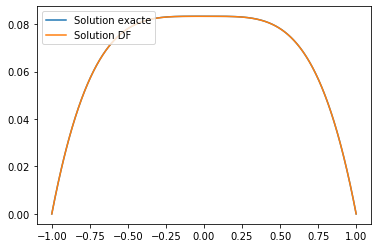

In [10]:
u,dom = methode_differences_finies(l,a,b,n)

# Représentation graphique de la solution différences finies (bleu) et de la solution exacte (rouge)
afficher_solutions(uth,dom_prec, "Solution exacte", u,dom,"Solution DF")

<ipython-input-2-e166c561ade3>:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  def integrale(f,b1,b2) : return quad(f,b1,b2)[0]


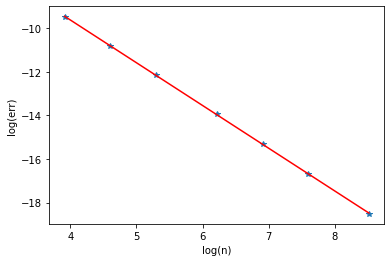

coefficient directeur :  -1.9627115116571499
ordonnée à l'origine  :  -1.7634671759392901


In [11]:
tracer_erreur(methode_differences_finies,sol_exa,l,a,b,"l2")

## Méthode des éléments finis

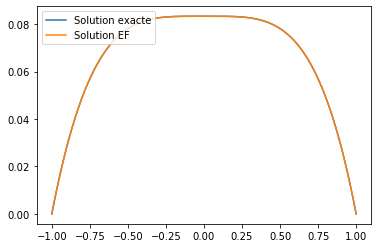

In [12]:
u2, dom2 = methode_elements_finis(l,a,b,n)

#Représentation graphique de la solution éléments finis et de la solution exacte
afficher_solutions(uth, dom_prec, "Solution exacte", u2, dom2, "Solution EF")

<ipython-input-2-e166c561ade3>:6: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  def integrale(f,b1,b2) : return quad(f,b1,b2)[0]


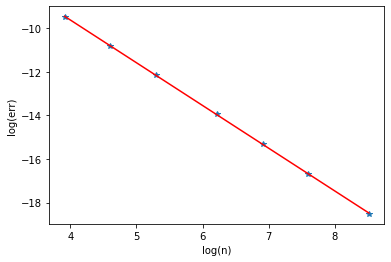

coefficient directeur :  -1.9619026327706668
ordonnée à l'origine  :  -1.7696299735047276


In [13]:
tracer_erreur(methode_elements_finis,sol_exa,l,a,b,"l2")